# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_3.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/sample_submission.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/class_map.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_3.parquet


In [4]:
import torch

debug=False
submission=False
batch_size=64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size=128
arch='pretrained'
model_name='se_resnext50_32x4d'
TH = 20

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('seresnext50_nowd_aug_nodrop_bs64')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 43.2 s, sys: 38.4 s, total: 1min 21s
Wall time: 8.53 s


In [10]:
#  import sys 

# # These are the usual ipython objects, including this one you are creating 
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# # Get a sorted list of the objects and their sizes 
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

<a id="dataset"></a>
# Dataset

In [11]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [12]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [13]:
train_dataset_noaug = BengaliAIDataset(train_images, train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [14]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [15]:
# print(image[:5,:5])
# print(20/255)

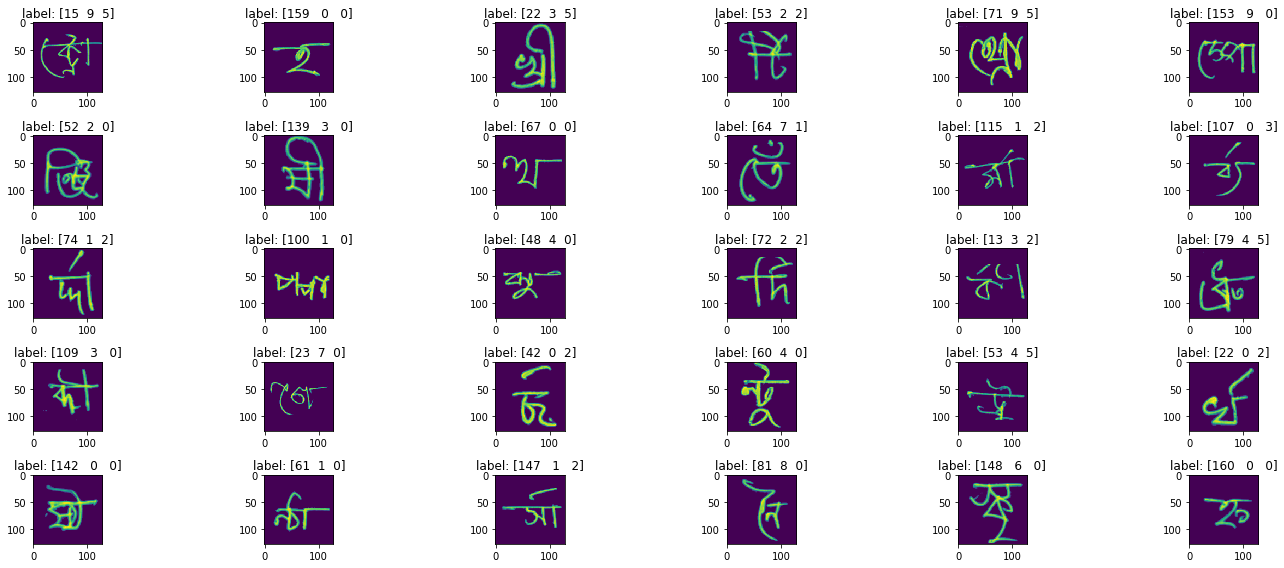

<Figure size 432x288 with 0 Axes>

In [16]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [17]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 15
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

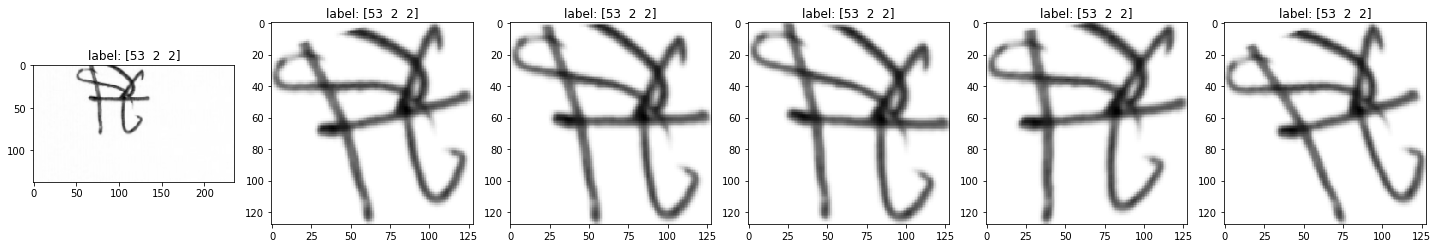

In [18]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[3]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = TH/255, thl=28.0/255, pad=16)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

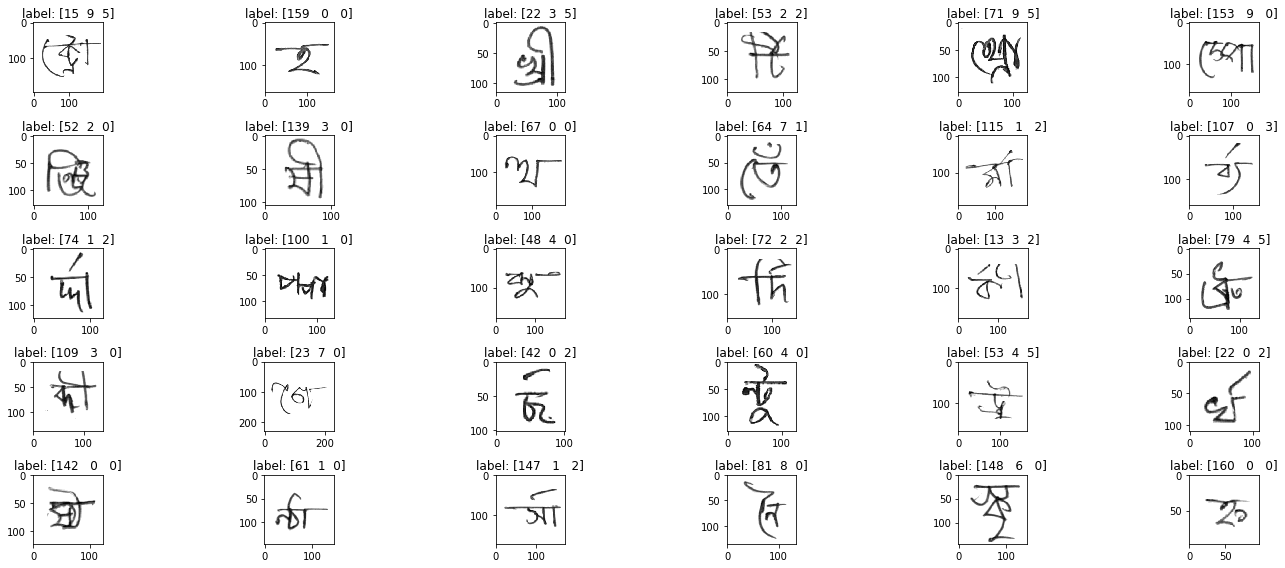

In [19]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

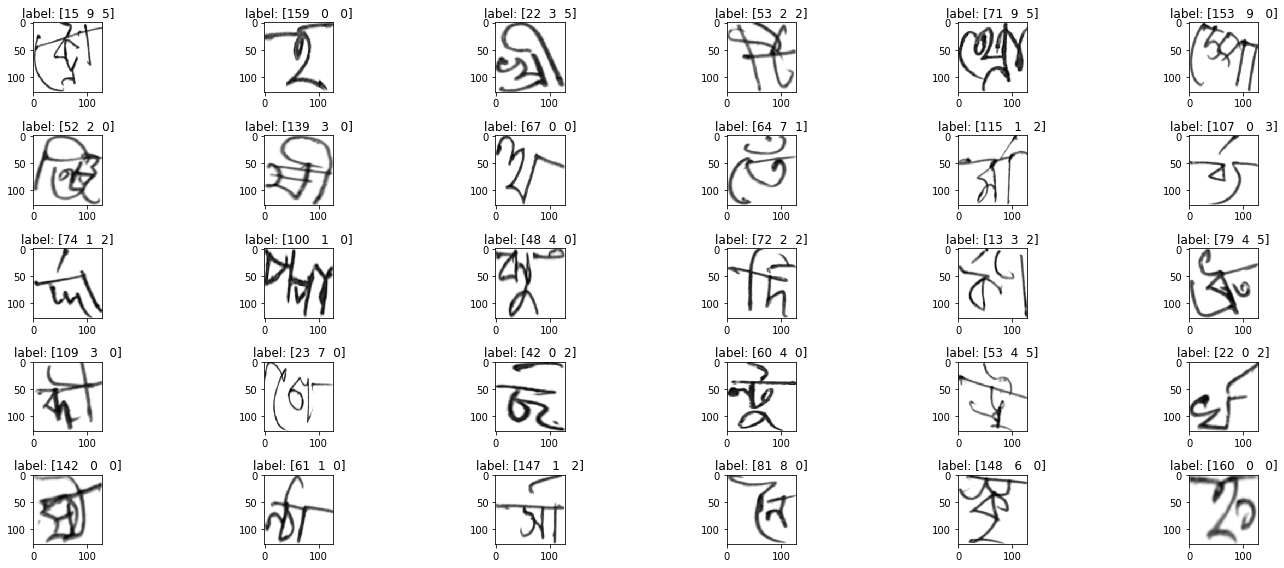

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [21]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=3, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [22]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

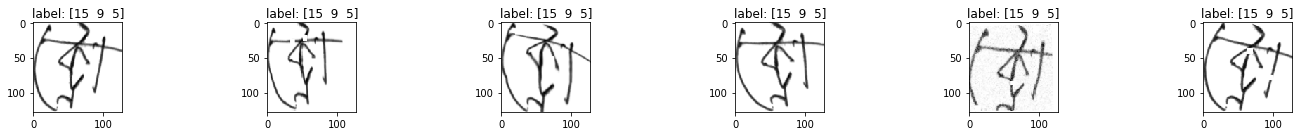

In [23]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

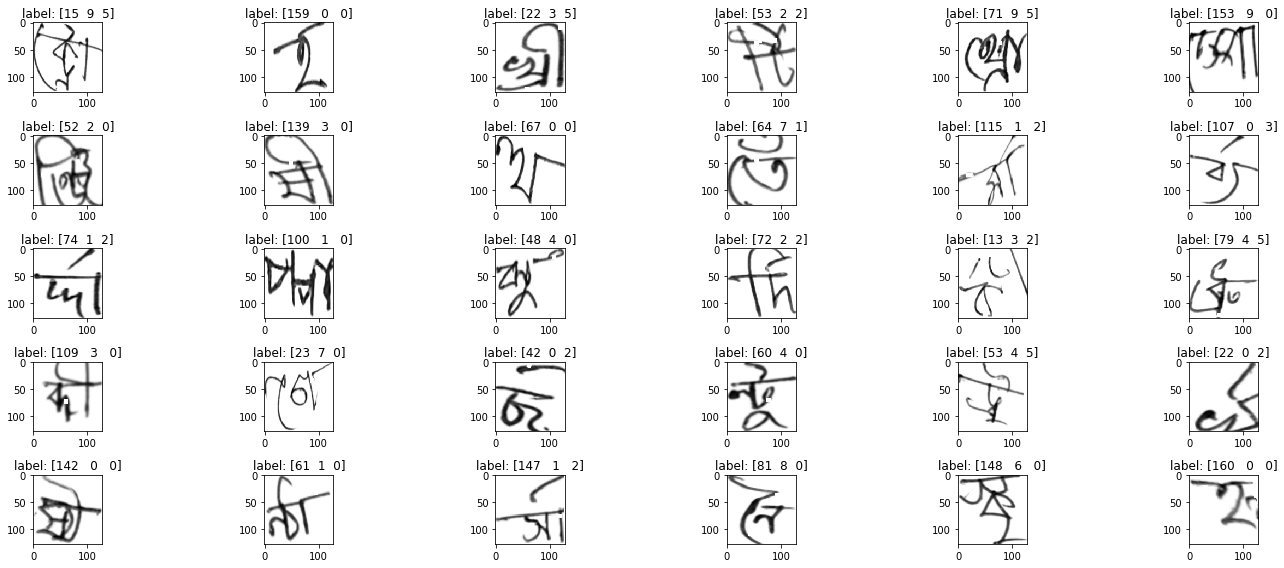

In [24]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [25]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [26]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [27]:
a = np.array([2,3])
b = np.array([4,5,6])

In [28]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [29]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [30]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [31]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [32]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [33]:
import CLR as CLR
import OneCycle as OneCycle

In [34]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [35]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [36]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

# --- Training setting ---

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [37]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [38]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        elem['mode'] = mode
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [39]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [40]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [41]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [42]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [43]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [44]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [45]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint != None:
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(checkpoint['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [46]:
def save_params(outdir, k, img_size, th, arch, model_name):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'arch': arch, 
               'model_name': model_name}
             )

In [47]:
import gc

n_epochs = 120
kfold = 2

if not os.path.exists(outdir):
    os.mkdir(outdir)

for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, model_name)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/2511 [00:00<?, ?it/s]/home/chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      0 train/loss  3.360967 train/loss_grapheme  2.178378 train/loss_vowel  0.625282 train/loss_consonant  0.557307 train/acc_grapheme  0.547096 train/acc_vowel  0.858258 train/acc_consonant  0.878380 train/recall  0.622431 val/loss  0.838379 val/loss_grapheme  0.524977 val/loss_vowel  0.154937 val/loss_consonant  0.158465 val/acc_grapheme  0.874154 val/acc_vowel  0.966516 val/acc_consonant  0.962980 val/recall  0.874737 lr  0.001000 elapsed_time  1235.063051 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      1 train/loss  1.027894 train/loss_grapheme  0.669050 train/loss_vowel  0.189856 train/loss_consonant  0.168988 train/acc_grapheme  0.845287 train/acc_vowel  0.953091 train/acc_consonant  0.955226 train/recall  0.848147 val/loss  0.549043 val/loss_grapheme  0.346890 val/loss_vowel  0.102749 val/loss_consonant  0.099404 val/acc_grapheme  0.911696 val/acc_vowel  0.974632 val/acc_consonant  0.973959 val/recall  0.907987 lr  0.001000 elapsed_time  2472.342585 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      2 train/loss  0.730575 train/loss_grapheme  0.467140 train/loss_vowel  0.138028 train/loss_consonant  0.125407 train/acc_grapheme  0.886190 train/acc_vowel  0.964686 train/acc_consonant  0.964269 train/recall  0.884563 val/loss  0.474798 val/loss_grapheme  0.311308 val/loss_vowel  0.083767 val/loss_consonant  0.079722 val/acc_grapheme  0.919886 val/acc_vowel  0.979237 val/acc_consonant  0.977992 val/recall  0.919174 lr  0.001000 elapsed_time  3703.435369 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      3 train/loss  0.592651 train/loss_grapheme  0.376302 train/loss_vowel  0.114155 train/loss_consonant  0.102194 train/acc_grapheme  0.905821 train/acc_vowel  0.969590 train/acc_consonant  0.970262 train/recall  0.903547 val/loss  0.408389 val/loss_grapheme  0.257387 val/loss_vowel  0.077415 val/loss_consonant  0.073588 val/acc_grapheme  0.933330 val/acc_vowel  0.980283 val/acc_consonant  0.979163 val/recall  0.929386 lr  0.001000 elapsed_time  4932.344648 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      4 train/loss  0.512378 train/loss_grapheme  0.323747 train/loss_vowel  0.099163 train/loss_consonant  0.089468 train/acc_grapheme  0.916326 train/acc_vowel  0.973331 train/acc_consonant  0.973679 train/recall  0.913020 val/loss  0.373570 val/loss_grapheme  0.239819 val/loss_vowel  0.067072 val/loss_consonant  0.066679 val/acc_grapheme  0.940052 val/acc_vowel  0.982872 val/acc_consonant  0.981129 val/recall  0.936912 lr  0.001000 elapsed_time  6159.545452 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      5 train/loss  0.452795 train/loss_grapheme  0.283845 train/loss_vowel  0.088710 train/loss_consonant  0.080239 train/acc_grapheme  0.925886 train/acc_vowel  0.976250 train/acc_consonant  0.976412 train/recall  0.922598 val/loss  0.344034 val/loss_grapheme  0.218855 val/loss_vowel  0.060519 val/loss_consonant  0.064659 val/acc_grapheme  0.944483 val/acc_vowel  0.984739 val/acc_consonant  0.981677 val/recall  0.940529 lr  0.001000 elapsed_time  7385.295476 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      6 train/loss  0.409114 train/loss_grapheme  0.255116 train/loss_vowel  0.081275 train/loss_consonant  0.072724 train/acc_grapheme  0.931961 train/acc_vowel  0.977793 train/acc_consonant  0.978248 train/recall  0.928999 val/loss  0.342683 val/loss_grapheme  0.222133 val/loss_vowel  0.060134 val/loss_consonant  0.060416 val/acc_grapheme  0.944458 val/acc_vowel  0.985013 val/acc_consonant  0.983245 val/recall  0.940525 lr  0.001000 elapsed_time  8612.441921 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      7 train/loss  0.372248 train/loss_grapheme  0.231558 train/loss_vowel  0.073084 train/loss_consonant  0.067606 train/acc_grapheme  0.937998 train/acc_vowel  0.980357 train/acc_consonant  0.980146 train/recall  0.934382 val/loss  0.333944 val/loss_grapheme  0.214871 val/loss_vowel  0.060251 val/loss_consonant  0.058822 val/acc_grapheme  0.945130 val/acc_vowel  0.984913 val/acc_consonant  0.983768 val/recall  0.943194 lr  0.001000 elapsed_time  9840.491546 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      8 train/loss  0.344213 train/loss_grapheme  0.211876 train/loss_vowel  0.069992 train/loss_consonant  0.062346 train/acc_grapheme  0.942411 train/acc_vowel  0.981111 train/acc_consonant  0.981727 train/recall  0.938575 val/loss  0.321635 val/loss_grapheme  0.204957 val/loss_vowel  0.061153 val/loss_consonant  0.055525 val/acc_grapheme  0.947819 val/acc_vowel  0.984266 val/acc_consonant  0.984988 val/recall  0.943899 lr  0.001000 elapsed_time  11069.024184 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      9 train/loss  0.324151 train/loss_grapheme  0.199700 train/loss_vowel  0.065248 train/loss_consonant  0.059203 train/acc_grapheme  0.945261 train/acc_vowel  0.982044 train/acc_consonant  0.982324 train/recall  0.941549 val/loss  0.329097 val/loss_grapheme  0.204257 val/loss_vowel  0.060556 val/loss_consonant  0.064284 val/acc_grapheme  0.947023 val/acc_vowel  0.985137 val/acc_consonant  0.981727 val/recall  0.943187 lr  0.001000 elapsed_time  12295.006872 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     10 train/loss  0.301263 train/loss_grapheme  0.183050 train/loss_vowel  0.061412 train/loss_consonant  0.056801 train/acc_grapheme  0.949282 train/acc_vowel  0.983420 train/acc_consonant  0.983158 train/recall  0.945680 val/loss  0.314894 val/loss_grapheme  0.200801 val/loss_vowel  0.056985 val/loss_consonant  0.057108 val/acc_grapheme  0.948939 val/acc_vowel  0.985909 val/acc_consonant  0.984565 val/recall  0.947236 lr  0.001000 elapsed_time  13526.252443 mode 011 


100%|██████████| 628/628 [01:50<00:00,  5.68it/s]


epoch     11 train/loss  0.284054 train/loss_grapheme  0.172981 train/loss_vowel  0.057668 train/loss_consonant  0.053405 train/acc_grapheme  0.951460 train/acc_vowel  0.984247 train/acc_consonant  0.984316 train/recall  0.947957 val/loss  0.304207 val/loss_grapheme  0.195540 val/loss_vowel  0.053302 val/loss_consonant  0.055366 val/acc_grapheme  0.950383 val/acc_vowel  0.986532 val/acc_consonant  0.984814 val/recall  0.946922 lr  0.001000 elapsed_time  14752.400349 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     12 train/loss  0.274431 train/loss_grapheme  0.166856 train/loss_vowel  0.055995 train/loss_consonant  0.051580 train/acc_grapheme  0.953022 train/acc_vowel  0.984546 train/acc_consonant  0.984384 train/recall  0.949078 val/loss  0.296688 val/loss_grapheme  0.185793 val/loss_vowel  0.056902 val/loss_consonant  0.053993 val/acc_grapheme  0.952275 val/acc_vowel  0.985984 val/acc_consonant  0.985859 val/recall  0.948998 lr  0.001000 elapsed_time  15969.971968 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     13 train/loss  0.253007 train/loss_grapheme  0.154253 train/loss_vowel  0.051872 train/loss_consonant  0.046882 train/acc_grapheme  0.956601 train/acc_vowel  0.985816 train/acc_consonant  0.985922 train/recall  0.953431 val/loss  0.302303 val/loss_grapheme  0.188671 val/loss_vowel  0.057090 val/loss_consonant  0.056542 val/acc_grapheme  0.952126 val/acc_vowel  0.985959 val/acc_consonant  0.984515 val/recall  0.948166 lr  0.001000 elapsed_time  17188.452760 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     14 train/loss  0.245694 train/loss_grapheme  0.149802 train/loss_vowel  0.050006 train/loss_consonant  0.045886 train/acc_grapheme  0.957659 train/acc_vowel  0.985747 train/acc_consonant  0.986034 train/recall  0.953987 val/loss  0.305512 val/loss_grapheme  0.191472 val/loss_vowel  0.056638 val/loss_consonant  0.057401 val/acc_grapheme  0.951056 val/acc_vowel  0.985461 val/acc_consonant  0.984689 val/recall  0.946503 lr  0.001000 elapsed_time  18406.454551 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     15 train/loss  0.230549 train/loss_grapheme  0.139343 train/loss_vowel  0.047556 train/loss_consonant  0.043650 train/acc_grapheme  0.960005 train/acc_vowel  0.986588 train/acc_consonant  0.986830 train/recall  0.956587 val/loss  0.293803 val/loss_grapheme  0.188390 val/loss_vowel  0.052663 val/loss_consonant  0.052749 val/acc_grapheme  0.954043 val/acc_vowel  0.987029 val/acc_consonant  0.985959 val/recall  0.951064 lr  0.001000 elapsed_time  19623.868279 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     16 train/loss  0.224864 train/loss_grapheme  0.135088 train/loss_vowel  0.047376 train/loss_consonant  0.042399 train/acc_grapheme  0.960746 train/acc_vowel  0.986563 train/acc_consonant  0.987036 train/recall  0.956981 val/loss  0.294272 val/loss_grapheme  0.186021 val/loss_vowel  0.054116 val/loss_consonant  0.054135 val/acc_grapheme  0.951454 val/acc_vowel  0.986855 val/acc_consonant  0.985337 val/recall  0.949115 lr  0.001000 elapsed_time  20843.565564 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     17 train/loss  0.215058 train/loss_grapheme  0.129229 train/loss_vowel  0.044137 train/loss_consonant  0.041692 train/acc_grapheme  0.962980 train/acc_vowel  0.987658 train/acc_consonant  0.987353 train/recall  0.959652 val/loss  0.292489 val/loss_grapheme  0.186053 val/loss_vowel  0.053922 val/loss_consonant  0.052514 val/acc_grapheme  0.953794 val/acc_vowel  0.986731 val/acc_consonant  0.985984 val/recall  0.950214 lr  0.001000 elapsed_time  22067.689872 mode 010 


100%|██████████| 628/628 [01:51<00:00,  5.62it/s]


epoch     18 train/loss  0.205700 train/loss_grapheme  0.123527 train/loss_vowel  0.042785 train/loss_consonant  0.039388 train/acc_grapheme  0.964431 train/acc_vowel  0.988019 train/acc_consonant  0.988374 train/recall  0.961167 val/loss  0.288437 val/loss_grapheme  0.179647 val/loss_vowel  0.053372 val/loss_consonant  0.055418 val/acc_grapheme  0.954939 val/acc_vowel  0.986830 val/acc_consonant  0.985312 val/recall  0.951648 lr  0.001000 elapsed_time  23296.055175 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     19 train/loss  0.198472 train/loss_grapheme  0.118814 train/loss_vowel  0.041910 train/loss_consonant  0.037749 train/acc_grapheme  0.966005 train/acc_vowel  0.987963 train/acc_consonant  0.988405 train/recall  0.962531 val/loss  0.292716 val/loss_grapheme  0.183040 val/loss_vowel  0.053877 val/loss_consonant  0.055798 val/acc_grapheme  0.954392 val/acc_vowel  0.986407 val/acc_consonant  0.984714 val/recall  0.949836 lr  0.001000 elapsed_time  24523.767503 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     20 train/loss  0.188533 train/loss_grapheme  0.112876 train/loss_vowel  0.039576 train/loss_consonant  0.036081 train/acc_grapheme  0.967150 train/acc_vowel  0.988704 train/acc_consonant  0.988953 train/recall  0.964280 val/loss  0.301987 val/loss_grapheme  0.189370 val/loss_vowel  0.056653 val/loss_consonant  0.055964 val/acc_grapheme  0.952724 val/acc_vowel  0.986556 val/acc_consonant  0.985735 val/recall  0.950150 lr  0.001000 elapsed_time  25750.819820 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     21 train/loss  0.185854 train/loss_grapheme  0.112793 train/loss_vowel  0.038742 train/loss_consonant  0.034319 train/acc_grapheme  0.966833 train/acc_vowel  0.989002 train/acc_consonant  0.989052 train/recall  0.964111 val/loss  0.295424 val/loss_grapheme  0.181304 val/loss_vowel  0.056343 val/loss_consonant  0.057777 val/acc_grapheme  0.955014 val/acc_vowel  0.986855 val/acc_consonant  0.985685 val/recall  0.951712 lr  0.001000 elapsed_time  26968.801194 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     22 train/loss  0.183205 train/loss_grapheme  0.109141 train/loss_vowel  0.038828 train/loss_consonant  0.035237 train/acc_grapheme  0.968526 train/acc_vowel  0.988946 train/acc_consonant  0.989245 train/recall  0.965215 val/loss  0.299052 val/loss_grapheme  0.188536 val/loss_vowel  0.055913 val/loss_consonant  0.054603 val/acc_grapheme  0.954566 val/acc_vowel  0.986556 val/acc_consonant  0.984938 val/recall  0.950045 lr  0.001000 elapsed_time  28185.390204 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     23 train/loss  0.175114 train/loss_grapheme  0.103116 train/loss_vowel  0.038463 train/loss_consonant  0.033535 train/acc_grapheme  0.969864 train/acc_vowel  0.989189 train/acc_consonant  0.989731 train/recall  0.966474 val/loss  0.302159 val/loss_grapheme  0.185206 val/loss_vowel  0.054980 val/loss_consonant  0.061973 val/acc_grapheme  0.953246 val/acc_vowel  0.986507 val/acc_consonant  0.983743 val/recall  0.948785 lr  0.001000 elapsed_time  29414.575556 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     24 train/loss  0.168237 train/loss_grapheme  0.099881 train/loss_vowel  0.035527 train/loss_consonant  0.032830 train/acc_grapheme  0.970611 train/acc_vowel  0.989681 train/acc_consonant  0.990079 train/recall  0.967728 val/loss  0.289486 val/loss_grapheme  0.178519 val/loss_vowel  0.055666 val/loss_consonant  0.055302 val/acc_grapheme  0.955263 val/acc_vowel  0.986980 val/acc_consonant  0.986656 val/recall  0.951423 lr  0.001000 elapsed_time  30642.691374 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     25 train/loss  0.164165 train/loss_grapheme  0.097700 train/loss_vowel  0.034829 train/loss_consonant  0.031636 train/acc_grapheme  0.971264 train/acc_vowel  0.989743 train/acc_consonant  0.990148 train/recall  0.968023 val/loss  0.288433 val/loss_grapheme  0.179616 val/loss_vowel  0.054217 val/loss_consonant  0.054600 val/acc_grapheme  0.956533 val/acc_vowel  0.987104 val/acc_consonant  0.986407 val/recall  0.952855 lr  0.001000 elapsed_time  31860.641901 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     26 train/loss  0.157761 train/loss_grapheme  0.094961 train/loss_vowel  0.032316 train/loss_consonant  0.030484 train/acc_grapheme  0.971731 train/acc_vowel  0.990689 train/acc_consonant  0.990552 train/recall  0.968733 val/loss  0.291960 val/loss_grapheme  0.183768 val/loss_vowel  0.054036 val/loss_consonant  0.054156 val/acc_grapheme  0.955263 val/acc_vowel  0.987254 val/acc_consonant  0.985859 val/recall  0.950908 lr  0.001000 elapsed_time  33078.489298 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     27 train/loss  0.154883 train/loss_grapheme  0.091892 train/loss_vowel  0.032359 train/loss_consonant  0.030632 train/acc_grapheme  0.972627 train/acc_vowel  0.990502 train/acc_consonant  0.990789 train/recall  0.969429 val/loss  0.297452 val/loss_grapheme  0.184183 val/loss_vowel  0.056032 val/loss_consonant  0.057237 val/acc_grapheme  0.955860 val/acc_vowel  0.986955 val/acc_consonant  0.985187 val/recall  0.951067 lr  0.001000 elapsed_time  34308.570763 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     28 train/loss  0.152553 train/loss_grapheme  0.090141 train/loss_vowel  0.032178 train/loss_consonant  0.030235 train/acc_grapheme  0.973791 train/acc_vowel  0.990764 train/acc_consonant  0.990552 train/recall  0.970972 val/loss  0.295525 val/loss_grapheme  0.185924 val/loss_vowel  0.053315 val/loss_consonant  0.056285 val/acc_grapheme  0.955686 val/acc_vowel  0.987079 val/acc_consonant  0.985536 val/recall  0.951874 lr  0.001000 elapsed_time  35532.206391 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     29 train/loss  0.148401 train/loss_grapheme  0.087519 train/loss_vowel  0.031770 train/loss_consonant  0.029112 train/acc_grapheme  0.973717 train/acc_vowel  0.990764 train/acc_consonant  0.990907 train/recall  0.970807 val/loss  0.293625 val/loss_grapheme  0.183973 val/loss_vowel  0.052757 val/loss_consonant  0.056895 val/acc_grapheme  0.955089 val/acc_vowel  0.986855 val/acc_consonant  0.985461 val/recall  0.951789 lr  0.001000 elapsed_time  36757.824691 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     30 train/loss  0.146636 train/loss_grapheme  0.085962 train/loss_vowel  0.031986 train/loss_consonant  0.028688 train/acc_grapheme  0.974208 train/acc_vowel  0.990782 train/acc_consonant  0.990894 train/recall  0.970923 val/loss  0.294398 val/loss_grapheme  0.181240 val/loss_vowel  0.058122 val/loss_consonant  0.055036 val/acc_grapheme  0.955636 val/acc_vowel  0.986332 val/acc_consonant  0.986133 val/recall  0.951944 lr  0.001000 elapsed_time  37989.834944 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     31 train/loss  0.141608 train/loss_grapheme  0.082634 train/loss_vowel  0.030957 train/loss_consonant  0.028017 train/acc_grapheme  0.975061 train/acc_vowel  0.991156 train/acc_consonant  0.991318 train/recall  0.972337 val/loss  0.303647 val/loss_grapheme  0.191807 val/loss_vowel  0.057210 val/loss_consonant  0.054630 val/acc_grapheme  0.954616 val/acc_vowel  0.986581 val/acc_consonant  0.986955 val/recall  0.951268 lr  0.001000 elapsed_time  39217.205823 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     32 train/loss  0.141321 train/loss_grapheme  0.083338 train/loss_vowel  0.030309 train/loss_consonant  0.027674 train/acc_grapheme  0.975223 train/acc_vowel  0.991125 train/acc_consonant  0.991343 train/recall  0.972547 val/loss  0.301691 val/loss_grapheme  0.191486 val/loss_vowel  0.055144 val/loss_consonant  0.055062 val/acc_grapheme  0.954889 val/acc_vowel  0.987303 val/acc_consonant  0.986258 val/recall  0.951915 lr  0.001000 elapsed_time  40443.311104 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     33 train/loss  0.140197 train/loss_grapheme  0.081809 train/loss_vowel  0.031109 train/loss_consonant  0.027279 train/acc_grapheme  0.975708 train/acc_vowel  0.991075 train/acc_consonant  0.991511 train/recall  0.972265 val/loss  0.306296 val/loss_grapheme  0.191119 val/loss_vowel  0.054977 val/loss_consonant  0.060200 val/acc_grapheme  0.953670 val/acc_vowel  0.987577 val/acc_consonant  0.984615 val/recall  0.950479 lr  0.001000 elapsed_time  41667.774596 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     34 train/loss  0.135969 train/loss_grapheme  0.077911 train/loss_vowel  0.030120 train/loss_consonant  0.027938 train/acc_grapheme  0.976667 train/acc_vowel  0.991069 train/acc_consonant  0.991299 train/recall  0.973629 val/loss  0.304671 val/loss_grapheme  0.188678 val/loss_vowel  0.056479 val/loss_consonant  0.059515 val/acc_grapheme  0.955387 val/acc_vowel  0.986656 val/acc_consonant  0.985212 val/recall  0.951255 lr  0.001000 elapsed_time  42890.767118 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     35 train/loss  0.133064 train/loss_grapheme  0.077580 train/loss_vowel  0.029849 train/loss_consonant  0.025634 train/acc_grapheme  0.976791 train/acc_vowel  0.991193 train/acc_consonant  0.992046 train/recall  0.973962 val/loss  0.301439 val/loss_grapheme  0.184837 val/loss_vowel  0.056724 val/loss_consonant  0.059878 val/acc_grapheme  0.956159 val/acc_vowel  0.986706 val/acc_consonant  0.985137 val/recall  0.952148 lr  0.001000 elapsed_time  44112.871032 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     36 train/loss  0.129430 train/loss_grapheme  0.074477 train/loss_vowel  0.029622 train/loss_consonant  0.025331 train/acc_grapheme  0.977862 train/acc_vowel  0.991554 train/acc_consonant  0.992021 train/recall  0.975170 val/loss  0.303581 val/loss_grapheme  0.186263 val/loss_vowel  0.055802 val/loss_consonant  0.061516 val/acc_grapheme  0.956084 val/acc_vowel  0.987054 val/acc_consonant  0.985113 val/recall  0.952713 lr  0.001000 elapsed_time  45337.340595 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     37 train/loss  0.130662 train/loss_grapheme  0.076609 train/loss_vowel  0.027869 train/loss_consonant  0.026184 train/acc_grapheme  0.977183 train/acc_vowel  0.991735 train/acc_consonant  0.991872 train/recall  0.974519 val/loss  0.301964 val/loss_grapheme  0.187290 val/loss_vowel  0.055772 val/loss_consonant  0.058902 val/acc_grapheme  0.955238 val/acc_vowel  0.987054 val/acc_consonant  0.985909 val/recall  0.951558 lr  0.001000 elapsed_time  46560.688797 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     38 train/loss  0.120996 train/loss_grapheme  0.070994 train/loss_vowel  0.025868 train/loss_consonant  0.024134 train/acc_grapheme  0.978335 train/acc_vowel  0.992500 train/acc_consonant  0.992413 train/recall  0.976067 val/loss  0.325464 val/loss_grapheme  0.203581 val/loss_vowel  0.059823 val/loss_consonant  0.062060 val/acc_grapheme  0.953346 val/acc_vowel  0.986233 val/acc_consonant  0.985162 val/recall  0.949942 lr  0.001000 elapsed_time  47781.842980 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     39 train/loss  0.125286 train/loss_grapheme  0.073407 train/loss_vowel  0.026645 train/loss_consonant  0.025234 train/acc_grapheme  0.978223 train/acc_vowel  0.991921 train/acc_consonant  0.991977 train/recall  0.975592 val/loss  0.311079 val/loss_grapheme  0.195099 val/loss_vowel  0.057654 val/loss_consonant  0.058326 val/acc_grapheme  0.955786 val/acc_vowel  0.987403 val/acc_consonant  0.985461 val/recall  0.950494 lr  0.001000 elapsed_time  49000.479025 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     40 train/loss  0.119848 train/loss_grapheme  0.069794 train/loss_vowel  0.026460 train/loss_consonant  0.023593 train/acc_grapheme  0.978777 train/acc_vowel  0.992052 train/acc_consonant  0.992413 train/recall  0.976429 val/loss  0.301402 val/loss_grapheme  0.186538 val/loss_vowel  0.056536 val/loss_consonant  0.058329 val/acc_grapheme  0.956259 val/acc_vowel  0.986830 val/acc_consonant  0.986059 val/recall  0.951951 lr  0.001000 elapsed_time  50219.109101 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     41 train/loss  0.118885 train/loss_grapheme  0.069033 train/loss_vowel  0.025739 train/loss_consonant  0.024113 train/acc_grapheme  0.979100 train/acc_vowel  0.992289 train/acc_consonant  0.992208 train/recall  0.976139 val/loss  0.311563 val/loss_grapheme  0.192109 val/loss_vowel  0.060622 val/loss_consonant  0.058832 val/acc_grapheme  0.955711 val/acc_vowel  0.986308 val/acc_consonant  0.986009 val/recall  0.952401 lr  0.001000 elapsed_time  51441.750842 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     42 train/loss  0.120676 train/loss_grapheme  0.069520 train/loss_vowel  0.026879 train/loss_consonant  0.024278 train/acc_grapheme  0.979243 train/acc_vowel  0.992189 train/acc_consonant  0.992575 train/recall  0.976515 val/loss  0.303930 val/loss_grapheme  0.191092 val/loss_vowel  0.056745 val/loss_consonant  0.056093 val/acc_grapheme  0.956309 val/acc_vowel  0.987652 val/acc_consonant  0.986955 val/recall  0.953493 lr  0.001000 elapsed_time  52667.412973 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     43 train/loss  0.116582 train/loss_grapheme  0.066616 train/loss_vowel  0.026806 train/loss_consonant  0.023160 train/acc_grapheme  0.979673 train/acc_vowel  0.991990 train/acc_consonant  0.992768 train/recall  0.976753 val/loss  0.309016 val/loss_grapheme  0.192839 val/loss_vowel  0.058771 val/loss_consonant  0.057406 val/acc_grapheme  0.955387 val/acc_vowel  0.986457 val/acc_consonant  0.986681 val/recall  0.951589 lr  0.001000 elapsed_time  53899.895159 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     44 train/loss  0.115193 train/loss_grapheme  0.066570 train/loss_vowel  0.025660 train/loss_consonant  0.022963 train/acc_grapheme  0.979810 train/acc_vowel  0.992401 train/acc_consonant  0.992942 train/recall  0.977369 val/loss  0.311605 val/loss_grapheme  0.195583 val/loss_vowel  0.057573 val/loss_consonant  0.058449 val/acc_grapheme  0.955288 val/acc_vowel  0.986706 val/acc_consonant  0.985884 val/recall  0.952636 lr  0.001000 elapsed_time  55133.416597 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     45 train/loss  0.113948 train/loss_grapheme  0.066459 train/loss_vowel  0.024927 train/loss_consonant  0.022561 train/acc_grapheme  0.980096 train/acc_vowel  0.992488 train/acc_consonant  0.992556 train/recall  0.976778 val/loss  0.313703 val/loss_grapheme  0.191404 val/loss_vowel  0.061906 val/loss_consonant  0.060392 val/acc_grapheme  0.954367 val/acc_vowel  0.986009 val/acc_consonant  0.985710 val/recall  0.950698 lr  0.001000 elapsed_time  56366.335066 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     46 train/loss  0.115176 train/loss_grapheme  0.066704 train/loss_vowel  0.025817 train/loss_consonant  0.022654 train/acc_grapheme  0.979909 train/acc_vowel  0.992195 train/acc_consonant  0.992749 train/recall  0.977532 val/loss  0.310163 val/loss_grapheme  0.195246 val/loss_vowel  0.056388 val/loss_consonant  0.058528 val/acc_grapheme  0.955412 val/acc_vowel  0.987029 val/acc_consonant  0.986382 val/recall  0.952165 lr  0.001000 elapsed_time  57603.617291 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     47 train/loss  0.111311 train/loss_grapheme  0.063683 train/loss_vowel  0.025140 train/loss_consonant  0.022489 train/acc_grapheme  0.980326 train/acc_vowel  0.992619 train/acc_consonant  0.992986 train/recall  0.978029 val/loss  0.316794 val/loss_grapheme  0.201181 val/loss_vowel  0.055419 val/loss_consonant  0.060194 val/acc_grapheme  0.954093 val/acc_vowel  0.987204 val/acc_consonant  0.986233 val/recall  0.950887 lr  0.001000 elapsed_time  58844.816704 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     48 train/loss  0.109824 train/loss_grapheme  0.063222 train/loss_vowel  0.024312 train/loss_consonant  0.022289 train/acc_grapheme  0.980855 train/acc_vowel  0.992606 train/acc_consonant  0.993141 train/recall  0.978422 val/loss  0.309065 val/loss_grapheme  0.193583 val/loss_vowel  0.054291 val/loss_consonant  0.061192 val/acc_grapheme  0.955761 val/acc_vowel  0.988299 val/acc_consonant  0.985959 val/recall  0.952571 lr  0.001000 elapsed_time  60082.660432 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     49 train/loss  0.109840 train/loss_grapheme  0.065012 train/loss_vowel  0.023806 train/loss_consonant  0.021022 train/acc_grapheme  0.980389 train/acc_vowel  0.993079 train/acc_consonant  0.993434 train/recall  0.977972 val/loss  0.320317 val/loss_grapheme  0.199286 val/loss_vowel  0.058703 val/loss_consonant  0.062328 val/acc_grapheme  0.954865 val/acc_vowel  0.987453 val/acc_consonant  0.985834 val/recall  0.951319 lr  0.001000 elapsed_time  61313.059292 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     50 train/loss  0.107940 train/loss_grapheme  0.061704 train/loss_vowel  0.024604 train/loss_consonant  0.021632 train/acc_grapheme  0.981540 train/acc_vowel  0.992923 train/acc_consonant  0.993284 train/recall  0.978944 val/loss  0.311993 val/loss_grapheme  0.192880 val/loss_vowel  0.056377 val/loss_consonant  0.062736 val/acc_grapheme  0.956060 val/acc_vowel  0.987751 val/acc_consonant  0.985237 val/recall  0.952680 lr  0.001000 elapsed_time  62543.903092 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     51 train/loss  0.107085 train/loss_grapheme  0.061645 train/loss_vowel  0.023558 train/loss_consonant  0.021883 train/acc_grapheme  0.981335 train/acc_vowel  0.992874 train/acc_consonant  0.993085 train/recall  0.978764 val/loss  0.315473 val/loss_grapheme  0.193453 val/loss_vowel  0.056524 val/loss_consonant  0.065495 val/acc_grapheme  0.955163 val/acc_vowel  0.987677 val/acc_consonant  0.984913 val/recall  0.951610 lr  0.001000 elapsed_time  63779.940522 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     52 train/loss  0.109768 train/loss_grapheme  0.063481 train/loss_vowel  0.024241 train/loss_consonant  0.022046 train/acc_grapheme  0.980438 train/acc_vowel  0.992861 train/acc_consonant  0.993067 train/recall  0.978331 val/loss  0.311135 val/loss_grapheme  0.193611 val/loss_vowel  0.056662 val/loss_consonant  0.060862 val/acc_grapheme  0.955711 val/acc_vowel  0.987876 val/acc_consonant  0.985884 val/recall  0.951915 lr  0.001000 elapsed_time  65017.242706 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     53 train/loss  0.102741 train/loss_grapheme  0.058293 train/loss_vowel  0.023270 train/loss_consonant  0.021179 train/acc_grapheme  0.982598 train/acc_vowel  0.993172 train/acc_consonant  0.993291 train/recall  0.979907 val/loss  0.308605 val/loss_grapheme  0.194097 val/loss_vowel  0.057025 val/loss_consonant  0.057483 val/acc_grapheme  0.957030 val/acc_vowel  0.987602 val/acc_consonant  0.986357 val/recall  0.953151 lr  0.001000 elapsed_time  66253.658608 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     54 train/loss  0.107154 train/loss_grapheme  0.061477 train/loss_vowel  0.023909 train/loss_consonant  0.021768 train/acc_grapheme  0.981322 train/acc_vowel  0.992892 train/acc_consonant  0.993011 train/recall  0.978809 val/loss  0.305698 val/loss_grapheme  0.190443 val/loss_vowel  0.056720 val/loss_consonant  0.058536 val/acc_grapheme  0.955487 val/acc_vowel  0.986656 val/acc_consonant  0.986208 val/recall  0.951264 lr  0.001000 elapsed_time  67492.193800 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     55 train/loss  0.103320 train/loss_grapheme  0.058643 train/loss_vowel  0.023223 train/loss_consonant  0.021454 train/acc_grapheme  0.982324 train/acc_vowel  0.993179 train/acc_consonant  0.993166 train/recall  0.979753 val/loss  0.319201 val/loss_grapheme  0.200084 val/loss_vowel  0.057645 val/loss_consonant  0.061471 val/acc_grapheme  0.955512 val/acc_vowel  0.987677 val/acc_consonant  0.986208 val/recall  0.951474 lr  0.001000 elapsed_time  68725.924015 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     56 train/loss  0.101406 train/loss_grapheme  0.056542 train/loss_vowel  0.023809 train/loss_consonant  0.021056 train/acc_grapheme  0.982704 train/acc_vowel  0.993036 train/acc_consonant  0.993434 train/recall  0.980221 val/loss  0.321821 val/loss_grapheme  0.203745 val/loss_vowel  0.054985 val/loss_consonant  0.063092 val/acc_grapheme  0.956458 val/acc_vowel  0.987378 val/acc_consonant  0.986482 val/recall  0.953635 lr  0.001000 elapsed_time  69947.791721 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     57 train/loss  0.104893 train/loss_grapheme  0.060109 train/loss_vowel  0.023454 train/loss_consonant  0.021330 train/acc_grapheme  0.981969 train/acc_vowel  0.992899 train/acc_consonant  0.993210 train/recall  0.979584 val/loss  0.325018 val/loss_grapheme  0.204528 val/loss_vowel  0.056576 val/loss_consonant  0.063914 val/acc_grapheme  0.955611 val/acc_vowel  0.987751 val/acc_consonant  0.985909 val/recall  0.951544 lr  0.001000 elapsed_time  71169.283404 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     58 train/loss  0.101938 train/loss_grapheme  0.058307 train/loss_vowel  0.023392 train/loss_consonant  0.020239 train/acc_grapheme  0.982461 train/acc_vowel  0.993260 train/acc_consonant  0.993714 train/recall  0.980101 val/loss  0.319623 val/loss_grapheme  0.197736 val/loss_vowel  0.058311 val/loss_consonant  0.063577 val/acc_grapheme  0.955387 val/acc_vowel  0.987776 val/acc_consonant  0.985934 val/recall  0.951659 lr  0.001000 elapsed_time  72388.484421 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     59 train/loss  0.098685 train/loss_grapheme  0.056763 train/loss_vowel  0.022339 train/loss_consonant  0.019583 train/acc_grapheme  0.982511 train/acc_vowel  0.993222 train/acc_consonant  0.993714 train/recall  0.979515 val/loss  0.313207 val/loss_grapheme  0.189408 val/loss_vowel  0.058350 val/loss_consonant  0.065449 val/acc_grapheme  0.957180 val/acc_vowel  0.987702 val/acc_consonant  0.986930 val/recall  0.954514 lr  0.001000 elapsed_time  73611.505637 mode 101 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     60 train/loss  0.099304 train/loss_grapheme  0.056678 train/loss_vowel  0.022805 train/loss_consonant  0.019821 train/acc_grapheme  0.982965 train/acc_vowel  0.993160 train/acc_consonant  0.993496 train/recall  0.980396 val/loss  0.321382 val/loss_grapheme  0.197857 val/loss_vowel  0.061115 val/loss_consonant  0.062410 val/acc_grapheme  0.955960 val/acc_vowel  0.987054 val/acc_consonant  0.986133 val/recall  0.952391 lr  0.001000 elapsed_time  74831.491826 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     61 train/loss  0.099953 train/loss_grapheme  0.056463 train/loss_vowel  0.022557 train/loss_consonant  0.020933 train/acc_grapheme  0.983196 train/acc_vowel  0.993396 train/acc_consonant  0.993627 train/recall  0.980891 val/loss  0.316970 val/loss_grapheme  0.196269 val/loss_vowel  0.059989 val/loss_consonant  0.060712 val/acc_grapheme  0.955039 val/acc_vowel  0.987303 val/acc_consonant  0.985959 val/recall  0.950994 lr  0.001000 elapsed_time  76058.174913 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     62 train/loss  0.101698 train/loss_grapheme  0.058074 train/loss_vowel  0.023674 train/loss_consonant  0.019949 train/acc_grapheme  0.982660 train/acc_vowel  0.992886 train/acc_consonant  0.993515 train/recall  0.980409 val/loss  0.315783 val/loss_grapheme  0.194692 val/loss_vowel  0.059039 val/loss_consonant  0.062052 val/acc_grapheme  0.954641 val/acc_vowel  0.986955 val/acc_consonant  0.985635 val/recall  0.950900 lr  0.001000 elapsed_time  77283.995768 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     63 train/loss  0.098634 train/loss_grapheme  0.055920 train/loss_vowel  0.021878 train/loss_consonant  0.020837 train/acc_grapheme  0.982984 train/acc_vowel  0.993365 train/acc_consonant  0.993353 train/recall  0.980902 val/loss  0.318733 val/loss_grapheme  0.194408 val/loss_vowel  0.060644 val/loss_consonant  0.063680 val/acc_grapheme  0.957055 val/acc_vowel  0.987527 val/acc_consonant  0.986308 val/recall  0.952943 lr  0.001000 elapsed_time  78506.353778 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     64 train/loss  0.096744 train/loss_grapheme  0.055193 train/loss_vowel  0.021278 train/loss_consonant  0.020273 train/acc_grapheme  0.983382 train/acc_vowel  0.993515 train/acc_consonant  0.993757 train/recall  0.980978 val/loss  0.320921 val/loss_grapheme  0.202249 val/loss_vowel  0.058504 val/loss_consonant  0.060168 val/acc_grapheme  0.954964 val/acc_vowel  0.987328 val/acc_consonant  0.985685 val/recall  0.951500 lr  0.001000 elapsed_time  79725.754582 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     65 train/loss  0.098432 train/loss_grapheme  0.056059 train/loss_vowel  0.022521 train/loss_consonant  0.019853 train/acc_grapheme  0.982903 train/acc_vowel  0.993291 train/acc_consonant  0.993757 train/recall  0.980424 val/loss  0.321864 val/loss_grapheme  0.201845 val/loss_vowel  0.060007 val/loss_consonant  0.060013 val/acc_grapheme  0.955313 val/acc_vowel  0.987278 val/acc_consonant  0.985685 val/recall  0.952006 lr  0.001000 elapsed_time  80951.335372 mode 000 


100%|██████████| 628/628 [01:52<00:00,  5.58it/s]


epoch     66 train/loss  0.096075 train/loss_grapheme  0.054822 train/loss_vowel  0.021941 train/loss_consonant  0.019312 train/acc_grapheme  0.983140 train/acc_vowel  0.993340 train/acc_consonant  0.993764 train/recall  0.980830 val/loss  0.327397 val/loss_grapheme  0.202922 val/loss_vowel  0.060403 val/loss_consonant  0.064072 val/acc_grapheme  0.955985 val/acc_vowel  0.987602 val/acc_consonant  0.985760 val/recall  0.951931 lr  0.001000 elapsed_time  82183.871917 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     67 train/loss  0.096010 train/loss_grapheme  0.055195 train/loss_vowel  0.021806 train/loss_consonant  0.019009 train/acc_grapheme  0.983725 train/acc_vowel  0.993645 train/acc_consonant  0.994156 train/recall  0.981615 val/loss  0.321830 val/loss_grapheme  0.200664 val/loss_vowel  0.061272 val/loss_consonant  0.059894 val/acc_grapheme  0.956483 val/acc_vowel  0.987801 val/acc_consonant  0.986407 val/recall  0.952854 lr  0.001000 elapsed_time  83420.665955 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     68 train/loss  0.096311 train/loss_grapheme  0.054685 train/loss_vowel  0.022469 train/loss_consonant  0.019158 train/acc_grapheme  0.983401 train/acc_vowel  0.993378 train/acc_consonant  0.994044 train/recall  0.981218 val/loss  0.328240 val/loss_grapheme  0.205014 val/loss_vowel  0.058286 val/loss_consonant  0.064940 val/acc_grapheme  0.954192 val/acc_vowel  0.987602 val/acc_consonant  0.985187 val/recall  0.951011 lr  0.001000 elapsed_time  84656.597270 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     69 train/loss  0.097865 train/loss_grapheme  0.054858 train/loss_vowel  0.022928 train/loss_consonant  0.020078 train/acc_grapheme  0.983644 train/acc_vowel  0.993197 train/acc_consonant  0.993795 train/recall  0.981442 val/loss  0.319602 val/loss_grapheme  0.200383 val/loss_vowel  0.059181 val/loss_consonant  0.060038 val/acc_grapheme  0.955537 val/acc_vowel  0.987403 val/acc_consonant  0.986756 val/recall  0.952392 lr  0.001000 elapsed_time  85887.713221 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     70 train/loss  0.095646 train/loss_grapheme  0.053095 train/loss_vowel  0.022113 train/loss_consonant  0.020437 train/acc_grapheme  0.983880 train/acc_vowel  0.993571 train/acc_consonant  0.993621 train/recall  0.981985 val/loss  0.328997 val/loss_grapheme  0.203601 val/loss_vowel  0.060879 val/loss_consonant  0.064518 val/acc_grapheme  0.955437 val/acc_vowel  0.986980 val/acc_consonant  0.986332 val/recall  0.951637 lr  0.001000 elapsed_time  87114.004911 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     71 train/loss  0.096201 train/loss_grapheme  0.054937 train/loss_vowel  0.021358 train/loss_consonant  0.019906 train/acc_grapheme  0.983432 train/acc_vowel  0.993502 train/acc_consonant  0.993807 train/recall  0.981123 val/loss  0.325796 val/loss_grapheme  0.199484 val/loss_vowel  0.063804 val/loss_consonant  0.062508 val/acc_grapheme  0.956035 val/acc_vowel  0.987353 val/acc_consonant  0.986083 val/recall  0.952363 lr  0.001000 elapsed_time  88343.466334 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     72 train/loss  0.097336 train/loss_grapheme  0.055170 train/loss_vowel  0.022336 train/loss_consonant  0.019830 train/acc_grapheme  0.983669 train/acc_vowel  0.993384 train/acc_consonant  0.993577 train/recall  0.981275 val/loss  0.324001 val/loss_grapheme  0.199467 val/loss_vowel  0.060478 val/loss_consonant  0.064056 val/acc_grapheme  0.954342 val/acc_vowel  0.987378 val/acc_consonant  0.985610 val/recall  0.950893 lr  0.001000 elapsed_time  89573.222032 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     73 train/loss  0.091527 train/loss_grapheme  0.050875 train/loss_vowel  0.021554 train/loss_consonant  0.019099 train/acc_grapheme  0.984527 train/acc_vowel  0.993832 train/acc_consonant  0.994143 train/recall  0.982158 val/loss  0.323572 val/loss_grapheme  0.200603 val/loss_vowel  0.058585 val/loss_consonant  0.064384 val/acc_grapheme  0.955910 val/acc_vowel  0.987527 val/acc_consonant  0.985810 val/recall  0.951529 lr  0.001000 elapsed_time  90801.360706 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     74 train/loss  0.096068 train/loss_grapheme  0.053272 train/loss_vowel  0.022844 train/loss_consonant  0.019952 train/acc_grapheme  0.984223 train/acc_vowel  0.993297 train/acc_consonant  0.993583 train/recall  0.981530 val/loss  0.326920 val/loss_grapheme  0.205750 val/loss_vowel  0.059902 val/loss_consonant  0.061268 val/acc_grapheme  0.955835 val/acc_vowel  0.987502 val/acc_consonant  0.986656 val/recall  0.952177 lr  0.001000 elapsed_time  92026.833526 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     75 train/loss  0.092171 train/loss_grapheme  0.051164 train/loss_vowel  0.021126 train/loss_consonant  0.019881 train/acc_grapheme  0.984677 train/acc_vowel  0.993751 train/acc_consonant  0.993813 train/recall  0.982557 val/loss  0.322621 val/loss_grapheme  0.203744 val/loss_vowel  0.060129 val/loss_consonant  0.058748 val/acc_grapheme  0.956533 val/acc_vowel  0.987776 val/acc_consonant  0.985884 val/recall  0.952606 lr  0.001000 elapsed_time  93242.739651 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     76 train/loss  0.090502 train/loss_grapheme  0.051046 train/loss_vowel  0.021347 train/loss_consonant  0.018108 train/acc_grapheme  0.984496 train/acc_vowel  0.993452 train/acc_consonant  0.994243 train/recall  0.982352 val/loss  0.325291 val/loss_grapheme  0.202615 val/loss_vowel  0.060415 val/loss_consonant  0.062261 val/acc_grapheme  0.955611 val/acc_vowel  0.987428 val/acc_consonant  0.985834 val/recall  0.951486 lr  0.001000 elapsed_time  94460.194938 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     77 train/loss  0.093679 train/loss_grapheme  0.051495 train/loss_vowel  0.022140 train/loss_consonant  0.020045 train/acc_grapheme  0.984191 train/acc_vowel  0.993639 train/acc_consonant  0.993764 train/recall  0.981823 val/loss  0.321265 val/loss_grapheme  0.201083 val/loss_vowel  0.058888 val/loss_consonant  0.061294 val/acc_grapheme  0.955935 val/acc_vowel  0.987602 val/acc_consonant  0.986233 val/recall  0.953009 lr  0.001000 elapsed_time  95677.627282 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     78 train/loss  0.086403 train/loss_grapheme  0.048569 train/loss_vowel  0.019968 train/loss_consonant  0.017865 train/acc_grapheme  0.985231 train/acc_vowel  0.994448 train/acc_consonant  0.994361 train/recall  0.982971 val/loss  0.327637 val/loss_grapheme  0.207266 val/loss_vowel  0.058897 val/loss_consonant  0.061474 val/acc_grapheme  0.954889 val/acc_vowel  0.988050 val/acc_consonant  0.986108 val/recall  0.951699 lr  0.001000 elapsed_time  96893.729419 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     79 train/loss  0.090753 train/loss_grapheme  0.050267 train/loss_vowel  0.021898 train/loss_consonant  0.018588 train/acc_grapheme  0.984627 train/acc_vowel  0.993365 train/acc_consonant  0.994106 train/recall  0.982419 val/loss  0.320341 val/loss_grapheme  0.200095 val/loss_vowel  0.057516 val/loss_consonant  0.062730 val/acc_grapheme  0.956358 val/acc_vowel  0.987204 val/acc_consonant  0.986457 val/recall  0.952845 lr  0.001000 elapsed_time  98115.192524 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     80 train/loss  0.087107 train/loss_grapheme  0.048032 train/loss_vowel  0.020728 train/loss_consonant  0.018347 train/acc_grapheme  0.985368 train/acc_vowel  0.994000 train/acc_consonant  0.993926 train/recall  0.982980 val/loss  0.320668 val/loss_grapheme  0.199974 val/loss_vowel  0.059028 val/loss_consonant  0.061667 val/acc_grapheme  0.956906 val/acc_vowel  0.987478 val/acc_consonant  0.986656 val/recall  0.953576 lr  0.001000 elapsed_time  99345.641074 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     81 train/loss  0.089425 train/loss_grapheme  0.049458 train/loss_vowel  0.021343 train/loss_consonant  0.018623 train/acc_grapheme  0.984857 train/acc_vowel  0.993459 train/acc_consonant  0.994280 train/recall  0.982584 val/loss  0.334739 val/loss_grapheme  0.208979 val/loss_vowel  0.061399 val/loss_consonant  0.064361 val/acc_grapheme  0.954715 val/acc_vowel  0.986457 val/acc_consonant  0.985735 val/recall  0.950124 lr  0.001000 elapsed_time  100577.373067 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     82 train/loss  0.091959 train/loss_grapheme  0.051697 train/loss_vowel  0.021318 train/loss_consonant  0.018943 train/acc_grapheme  0.984994 train/acc_vowel  0.993546 train/acc_consonant  0.994299 train/recall  0.982643 val/loss  0.322920 val/loss_grapheme  0.200504 val/loss_vowel  0.059413 val/loss_consonant  0.063004 val/acc_grapheme  0.956010 val/acc_vowel  0.987627 val/acc_consonant  0.985561 val/recall  0.951761 lr  0.001000 elapsed_time  101799.665319 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     83 train/loss  0.091255 train/loss_grapheme  0.050455 train/loss_vowel  0.021825 train/loss_consonant  0.018976 train/acc_grapheme  0.984689 train/acc_vowel  0.993378 train/acc_consonant  0.994006 train/recall  0.982312 val/loss  0.323200 val/loss_grapheme  0.202704 val/loss_vowel  0.059332 val/loss_consonant  0.061164 val/acc_grapheme  0.955338 val/acc_vowel  0.986855 val/acc_consonant  0.986581 val/recall  0.951806 lr  0.001000 elapsed_time  103020.158753 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     84 train/loss  0.094692 train/loss_grapheme  0.053296 train/loss_vowel  0.022001 train/loss_consonant  0.019395 train/acc_grapheme  0.984092 train/acc_vowel  0.993328 train/acc_consonant  0.993882 train/recall  0.981761 val/loss  0.318187 val/loss_grapheme  0.197356 val/loss_vowel  0.059109 val/loss_consonant  0.061722 val/acc_grapheme  0.956333 val/acc_vowel  0.987527 val/acc_consonant  0.986183 val/recall  0.952225 lr  0.001000 elapsed_time  104249.711931 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     85 train/loss  0.076146 train/loss_grapheme  0.041654 train/loss_vowel  0.018146 train/loss_consonant  0.016346 train/acc_grapheme  0.987901 train/acc_vowel  0.994616 train/acc_consonant  0.994747 train/recall  0.986087 val/loss  0.315617 val/loss_grapheme  0.194748 val/loss_vowel  0.059040 val/loss_consonant  0.061830 val/acc_grapheme  0.957703 val/acc_vowel  0.988822 val/acc_consonant  0.986905 val/recall  0.955058 lr  0.000700 elapsed_time  105479.402589 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     86 train/loss  0.069024 train/loss_grapheme  0.037795 train/loss_vowel  0.016288 train/loss_consonant  0.014942 train/acc_grapheme  0.988766 train/acc_vowel  0.995251 train/acc_consonant  0.995301 train/recall  0.987009 val/loss  0.309185 val/loss_grapheme  0.191986 val/loss_vowel  0.056500 val/loss_consonant  0.060699 val/acc_grapheme  0.958997 val/acc_vowel  0.988424 val/acc_consonant  0.987079 val/recall  0.954889 lr  0.000700 elapsed_time  106711.294089 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     87 train/loss  0.067359 train/loss_grapheme  0.036102 train/loss_vowel  0.016484 train/loss_consonant  0.014773 train/acc_grapheme  0.989233 train/acc_vowel  0.995195 train/acc_consonant  0.995444 train/recall  0.987295 val/loss  0.322644 val/loss_grapheme  0.198689 val/loss_vowel  0.060429 val/loss_consonant  0.063526 val/acc_grapheme  0.959644 val/acc_vowel  0.987901 val/acc_consonant  0.986432 val/recall  0.955963 lr  0.000700 elapsed_time  107942.794668 mode 001 


100%|██████████| 628/628 [01:53<00:00,  5.52it/s]


epoch     88 train/loss  0.065652 train/loss_grapheme  0.035799 train/loss_vowel  0.015628 train/loss_consonant  0.014224 train/acc_grapheme  0.989681 train/acc_vowel  0.995525 train/acc_consonant  0.995631 train/recall  0.987815 val/loss  0.322261 val/loss_grapheme  0.201634 val/loss_vowel  0.060641 val/loss_consonant  0.059987 val/acc_grapheme  0.958524 val/acc_vowel  0.987602 val/acc_consonant  0.987005 val/recall  0.954143 lr  0.000700 elapsed_time  109176.028527 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     89 train/loss  0.063621 train/loss_grapheme  0.035187 train/loss_vowel  0.014816 train/loss_consonant  0.013619 train/acc_grapheme  0.989475 train/acc_vowel  0.995755 train/acc_consonant  0.995930 train/recall  0.988362 val/loss  0.321737 val/loss_grapheme  0.199493 val/loss_vowel  0.061576 val/loss_consonant  0.060668 val/acc_grapheme  0.958051 val/acc_vowel  0.988125 val/acc_consonant  0.987303 val/recall  0.954801 lr  0.000700 elapsed_time  110407.263575 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     90 train/loss  0.063422 train/loss_grapheme  0.034521 train/loss_vowel  0.015518 train/loss_consonant  0.013383 train/acc_grapheme  0.990135 train/acc_vowel  0.995650 train/acc_consonant  0.995867 train/recall  0.988377 val/loss  0.320352 val/loss_grapheme  0.198870 val/loss_vowel  0.062437 val/loss_consonant  0.059044 val/acc_grapheme  0.959147 val/acc_vowel  0.988548 val/acc_consonant  0.987428 val/recall  0.955896 lr  0.000700 elapsed_time  111638.532846 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     91 train/loss  0.063197 train/loss_grapheme  0.035569 train/loss_vowel  0.014366 train/loss_consonant  0.013263 train/acc_grapheme  0.989668 train/acc_vowel  0.995774 train/acc_consonant  0.995992 train/recall  0.988033 val/loss  0.318751 val/loss_grapheme  0.197426 val/loss_vowel  0.059383 val/loss_consonant  0.061942 val/acc_grapheme  0.958450 val/acc_vowel  0.988847 val/acc_consonant  0.987378 val/recall  0.954945 lr  0.000700 elapsed_time  112871.561197 mode 000 


100%|██████████| 628/628 [01:53<00:00,  5.54it/s]


epoch     92 train/loss  0.062940 train/loss_grapheme  0.033913 train/loss_vowel  0.015493 train/loss_consonant  0.013533 train/acc_grapheme  0.989774 train/acc_vowel  0.995500 train/acc_consonant  0.995874 train/recall  0.988176 val/loss  0.325768 val/loss_grapheme  0.201126 val/loss_vowel  0.063412 val/loss_consonant  0.061230 val/acc_grapheme  0.957553 val/acc_vowel  0.987826 val/acc_consonant  0.987328 val/recall  0.953551 lr  0.000700 elapsed_time  114103.391106 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     93 train/loss  0.063669 train/loss_grapheme  0.033569 train/loss_vowel  0.015825 train/loss_consonant  0.014275 train/acc_grapheme  0.990365 train/acc_vowel  0.995587 train/acc_consonant  0.995724 train/recall  0.988903 val/loss  0.318724 val/loss_grapheme  0.200198 val/loss_vowel  0.057038 val/loss_consonant  0.061487 val/acc_grapheme  0.958972 val/acc_vowel  0.988797 val/acc_consonant  0.986731 val/recall  0.955585 lr  0.000700 elapsed_time  115334.589748 mode 000 


100%|██████████| 628/628 [01:53<00:00,  5.55it/s]


epoch     94 train/loss  0.059709 train/loss_grapheme  0.032434 train/loss_vowel  0.014737 train/loss_consonant  0.012539 train/acc_grapheme  0.990291 train/acc_vowel  0.995799 train/acc_consonant  0.996116 train/recall  0.988796 val/loss  0.325849 val/loss_grapheme  0.201371 val/loss_vowel  0.060732 val/loss_consonant  0.063746 val/acc_grapheme  0.957728 val/acc_vowel  0.988324 val/acc_consonant  0.986581 val/recall  0.954211 lr  0.000700 elapsed_time  116562.373341 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     95 train/loss  0.060885 train/loss_grapheme  0.033374 train/loss_vowel  0.014125 train/loss_consonant  0.013386 train/acc_grapheme  0.990073 train/acc_vowel  0.995936 train/acc_consonant  0.995718 train/recall  0.988572 val/loss  0.316389 val/loss_grapheme  0.196834 val/loss_vowel  0.059537 val/loss_consonant  0.060018 val/acc_grapheme  0.959420 val/acc_vowel  0.988897 val/acc_consonant  0.987502 val/recall  0.955915 lr  0.000700 elapsed_time  117791.441080 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     96 train/loss  0.060136 train/loss_grapheme  0.032645 train/loss_vowel  0.014433 train/loss_consonant  0.013059 train/acc_grapheme  0.990484 train/acc_vowel  0.995730 train/acc_consonant  0.996017 train/recall  0.989039 val/loss  0.325791 val/loss_grapheme  0.201031 val/loss_vowel  0.059259 val/loss_consonant  0.065502 val/acc_grapheme  0.959196 val/acc_vowel  0.988449 val/acc_consonant  0.986830 val/recall  0.955221 lr  0.000700 elapsed_time  119023.201663 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     97 train/loss  0.066482 train/loss_grapheme  0.035744 train/loss_vowel  0.016587 train/loss_consonant  0.014151 train/acc_grapheme  0.989594 train/acc_vowel  0.995351 train/acc_consonant  0.995575 train/recall  0.987629 val/loss  0.327084 val/loss_grapheme  0.204424 val/loss_vowel  0.059129 val/loss_consonant  0.063532 val/acc_grapheme  0.958873 val/acc_vowel  0.988922 val/acc_consonant  0.987353 val/recall  0.956136 lr  0.000700 elapsed_time  120254.464957 mode 001 


100%|██████████| 628/628 [01:52<00:00,  5.57it/s]


epoch     98 train/loss  0.058499 train/loss_grapheme  0.032021 train/loss_vowel  0.013779 train/loss_consonant  0.012699 train/acc_grapheme  0.990552 train/acc_vowel  0.996098 train/acc_consonant  0.996235 train/recall  0.989050 val/loss  0.323297 val/loss_grapheme  0.201245 val/loss_vowel  0.059348 val/loss_consonant  0.062704 val/acc_grapheme  0.959495 val/acc_vowel  0.988922 val/acc_consonant  0.987453 val/recall  0.956133 lr  0.000700 elapsed_time  121484.046212 mode 000 


100%|██████████| 628/628 [01:51<00:00,  5.61it/s]


epoch     99 train/loss  0.059053 train/loss_grapheme  0.031889 train/loss_vowel  0.015048 train/loss_consonant  0.012116 train/acc_grapheme  0.990596 train/acc_vowel  0.995762 train/acc_consonant  0.996179 train/recall  0.989107 val/loss  0.337452 val/loss_grapheme  0.212201 val/loss_vowel  0.062495 val/loss_consonant  0.062756 val/acc_grapheme  0.957852 val/acc_vowel  0.987851 val/acc_consonant  0.986980 val/recall  0.954694 lr  0.000700 elapsed_time  122714.259753 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    100 train/loss  0.062124 train/loss_grapheme  0.034241 train/loss_vowel  0.014603 train/loss_consonant  0.013280 train/acc_grapheme  0.989824 train/acc_vowel  0.995936 train/acc_consonant  0.996135 train/recall  0.988483 val/loss  0.333871 val/loss_grapheme  0.209657 val/loss_vowel  0.059758 val/loss_consonant  0.064456 val/acc_grapheme  0.958798 val/acc_vowel  0.987901 val/acc_consonant  0.986631 val/recall  0.955163 lr  0.000700 elapsed_time  123942.078247 mode 000 


100%|██████████| 628/628 [01:52<00:00,  5.57it/s]


epoch    101 train/loss  0.059627 train/loss_grapheme  0.032246 train/loss_vowel  0.014507 train/loss_consonant  0.012874 train/acc_grapheme  0.990565 train/acc_vowel  0.995811 train/acc_consonant  0.996079 train/recall  0.988979 val/loss  0.336125 val/loss_grapheme  0.210800 val/loss_vowel  0.062806 val/loss_consonant  0.062519 val/acc_grapheme  0.956856 val/acc_vowel  0.988424 val/acc_consonant  0.987179 val/recall  0.953857 lr  0.000700 elapsed_time  125167.694375 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    102 train/loss  0.060394 train/loss_grapheme  0.034058 train/loss_vowel  0.013404 train/loss_consonant  0.012931 train/acc_grapheme  0.990067 train/acc_vowel  0.996228 train/acc_consonant  0.996222 train/recall  0.988815 val/loss  0.336801 val/loss_grapheme  0.209455 val/loss_vowel  0.063803 val/loss_consonant  0.063543 val/acc_grapheme  0.957952 val/acc_vowel  0.988249 val/acc_consonant  0.987154 val/recall  0.954599 lr  0.000700 elapsed_time  126397.182081 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    103 train/loss  0.059055 train/loss_grapheme  0.031501 train/loss_vowel  0.014504 train/loss_consonant  0.013050 train/acc_grapheme  0.990832 train/acc_vowel  0.996011 train/acc_consonant  0.995961 train/recall  0.989367 val/loss  0.332844 val/loss_grapheme  0.210685 val/loss_vowel  0.060167 val/loss_consonant  0.061992 val/acc_grapheme  0.957653 val/acc_vowel  0.988772 val/acc_consonant  0.986855 val/recall  0.954729 lr  0.000700 elapsed_time  127621.564892 mode 000 


100%|██████████| 628/628 [01:52<00:00,  5.57it/s]


epoch    104 train/loss  0.062455 train/loss_grapheme  0.032975 train/loss_vowel  0.016068 train/loss_consonant  0.013413 train/acc_grapheme  0.990229 train/acc_vowel  0.995425 train/acc_consonant  0.996085 train/recall  0.988669 val/loss  0.336047 val/loss_grapheme  0.213321 val/loss_vowel  0.059979 val/loss_consonant  0.062747 val/acc_grapheme  0.958947 val/acc_vowel  0.988374 val/acc_consonant  0.986880 val/recall  0.955082 lr  0.000700 elapsed_time  128843.831363 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    105 train/loss  0.050986 train/loss_grapheme  0.027748 train/loss_vowel  0.012057 train/loss_consonant  0.011182 train/acc_grapheme  0.992027 train/acc_vowel  0.996564 train/acc_consonant  0.996620 train/recall  0.990914 val/loss  0.334550 val/loss_grapheme  0.210559 val/loss_vowel  0.061245 val/loss_consonant  0.062746 val/acc_grapheme  0.959171 val/acc_vowel  0.988424 val/acc_consonant  0.987453 val/recall  0.956009 lr  0.000490 elapsed_time  130071.623361 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    106 train/loss  0.049486 train/loss_grapheme  0.025893 train/loss_vowel  0.012981 train/loss_consonant  0.010612 train/acc_grapheme  0.992699 train/acc_vowel  0.996639 train/acc_consonant  0.996813 train/recall  0.991318 val/loss  0.326471 val/loss_grapheme  0.207566 val/loss_vowel  0.058916 val/loss_consonant  0.059989 val/acc_grapheme  0.959893 val/acc_vowel  0.989146 val/acc_consonant  0.988200 val/recall  0.957078 lr  0.000490 elapsed_time  131299.540973 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    107 train/loss  0.044765 train/loss_grapheme  0.023945 train/loss_vowel  0.011204 train/loss_consonant  0.009616 train/acc_grapheme  0.993253 train/acc_vowel  0.996857 train/acc_consonant  0.997181 train/recall  0.992144 val/loss  0.345245 val/loss_grapheme  0.215861 val/loss_vowel  0.064722 val/loss_consonant  0.064662 val/acc_grapheme  0.958599 val/acc_vowel  0.988399 val/acc_consonant  0.987602 val/recall  0.955187 lr  0.000490 elapsed_time  132525.003500 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    108 train/loss  0.045045 train/loss_grapheme  0.023563 train/loss_vowel  0.011677 train/loss_consonant  0.009805 train/acc_grapheme  0.993204 train/acc_vowel  0.996714 train/acc_consonant  0.997149 train/recall  0.992099 val/loss  0.320882 val/loss_grapheme  0.198381 val/loss_vowel  0.063092 val/loss_consonant  0.059409 val/acc_grapheme  0.959296 val/acc_vowel  0.988498 val/acc_consonant  0.988249 val/recall  0.956438 lr  0.000490 elapsed_time  133750.592486 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    109 train/loss  0.044838 train/loss_grapheme  0.024075 train/loss_vowel  0.011421 train/loss_consonant  0.009342 train/acc_grapheme  0.993378 train/acc_vowel  0.996720 train/acc_consonant  0.997249 train/recall  0.992215 val/loss  0.333518 val/loss_grapheme  0.210279 val/loss_vowel  0.061059 val/loss_consonant  0.062179 val/acc_grapheme  0.958748 val/acc_vowel  0.988847 val/acc_consonant  0.986980 val/recall  0.954725 lr  0.000490 elapsed_time  134980.361029 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    110 train/loss  0.043887 train/loss_grapheme  0.022937 train/loss_vowel  0.011266 train/loss_consonant  0.009684 train/acc_grapheme  0.993459 train/acc_vowel  0.996894 train/acc_consonant  0.997187 train/recall  0.992412 val/loss  0.327856 val/loss_grapheme  0.203575 val/loss_vowel  0.061026 val/loss_consonant  0.063255 val/acc_grapheme  0.959620 val/acc_vowel  0.988996 val/acc_consonant  0.986955 val/recall  0.956172 lr  0.000490 elapsed_time  136217.617280 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    111 train/loss  0.044571 train/loss_grapheme  0.023000 train/loss_vowel  0.011592 train/loss_consonant  0.009979 train/acc_grapheme  0.993484 train/acc_vowel  0.996813 train/acc_consonant  0.996988 train/recall  0.992370 val/loss  0.333698 val/loss_grapheme  0.211305 val/loss_vowel  0.058752 val/loss_consonant  0.063642 val/acc_grapheme  0.958947 val/acc_vowel  0.988722 val/acc_consonant  0.987577 val/recall  0.955246 lr  0.000490 elapsed_time  137442.459555 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    112 train/loss  0.042639 train/loss_grapheme  0.023223 train/loss_vowel  0.010351 train/loss_consonant  0.009065 train/acc_grapheme  0.993378 train/acc_vowel  0.997262 train/acc_consonant  0.997262 train/recall  0.992501 val/loss  0.335315 val/loss_grapheme  0.212260 val/loss_vowel  0.059612 val/loss_consonant  0.063444 val/acc_grapheme  0.958250 val/acc_vowel  0.989046 val/acc_consonant  0.987751 val/recall  0.955027 lr  0.000490 elapsed_time  138667.624939 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    113 train/loss  0.045217 train/loss_grapheme  0.023509 train/loss_vowel  0.012111 train/loss_consonant  0.009598 train/acc_grapheme  0.993415 train/acc_vowel  0.996757 train/acc_consonant  0.997199 train/recall  0.992188 val/loss  0.332257 val/loss_grapheme  0.211419 val/loss_vowel  0.057515 val/loss_consonant  0.063324 val/acc_grapheme  0.958947 val/acc_vowel  0.989021 val/acc_consonant  0.987527 val/recall  0.955966 lr  0.000490 elapsed_time  139894.299967 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    114 train/loss  0.043067 train/loss_grapheme  0.022721 train/loss_vowel  0.010850 train/loss_consonant  0.009496 train/acc_grapheme  0.993515 train/acc_vowel  0.996832 train/acc_consonant  0.997168 train/recall  0.992250 val/loss  0.331852 val/loss_grapheme  0.207461 val/loss_vowel  0.061071 val/loss_consonant  0.063320 val/acc_grapheme  0.959396 val/acc_vowel  0.988548 val/acc_consonant  0.987453 val/recall  0.955637 lr  0.000490 elapsed_time  141122.296893 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    115 train/loss  0.042867 train/loss_grapheme  0.022575 train/loss_vowel  0.010535 train/loss_consonant  0.009757 train/acc_grapheme  0.993614 train/acc_vowel  0.997069 train/acc_consonant  0.997293 train/recall  0.992631 val/loss  0.341678 val/loss_grapheme  0.215624 val/loss_vowel  0.062314 val/loss_consonant  0.063740 val/acc_grapheme  0.959221 val/acc_vowel  0.988424 val/acc_consonant  0.987876 val/recall  0.955432 lr  0.000490 elapsed_time  142345.258441 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    116 train/loss  0.040757 train/loss_grapheme  0.020974 train/loss_vowel  0.010975 train/loss_consonant  0.008807 train/acc_grapheme  0.994038 train/acc_vowel  0.997019 train/acc_consonant  0.997405 train/recall  0.992896 val/loss  0.342115 val/loss_grapheme  0.215284 val/loss_vowel  0.062289 val/loss_consonant  0.064543 val/acc_grapheme  0.959171 val/acc_vowel  0.989220 val/acc_consonant  0.987727 val/recall  0.955573 lr  0.000490 elapsed_time  143570.057017 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    117 train/loss  0.041177 train/loss_grapheme  0.021192 train/loss_vowel  0.010466 train/loss_consonant  0.009519 train/acc_grapheme  0.994100 train/acc_vowel  0.996944 train/acc_consonant  0.997149 train/recall  0.992975 val/loss  0.343085 val/loss_grapheme  0.216713 val/loss_vowel  0.061234 val/loss_consonant  0.065138 val/acc_grapheme  0.958400 val/acc_vowel  0.989270 val/acc_consonant  0.987378 val/recall  0.954919 lr  0.000490 elapsed_time  144799.782188 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    118 train/loss  0.041794 train/loss_grapheme  0.022604 train/loss_vowel  0.009868 train/loss_consonant  0.009323 train/acc_grapheme  0.993627 train/acc_vowel  0.997243 train/acc_consonant  0.997280 train/recall  0.992600 val/loss  0.340766 val/loss_grapheme  0.210697 val/loss_vowel  0.064735 val/loss_consonant  0.065334 val/acc_grapheme  0.958201 val/acc_vowel  0.988349 val/acc_consonant  0.987602 val/recall  0.954796 lr  0.000490 elapsed_time  146034.359832 mode 000 


100%|██████████| 628/628 [01:53<00:00,  5.55it/s]


epoch    119 train/loss  0.042249 train/loss_grapheme  0.021296 train/loss_vowel  0.010872 train/loss_consonant  0.010082 train/acc_grapheme  0.994118 train/acc_vowel  0.997131 train/acc_consonant  0.997056 train/recall  0.992706 val/loss  0.340398 val/loss_grapheme  0.212235 val/loss_vowel  0.062766 val/loss_consonant  0.065397 val/acc_grapheme  0.958624 val/acc_vowel  0.989046 val/acc_consonant  0.987677 val/recall  0.955477 lr  0.000490 elapsed_time  147271.104793 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      0 train/loss  3.294538 train/loss_grapheme  2.085381 train/loss_vowel  0.640449 train/loss_consonant  0.568709 train/acc_grapheme  0.567510 train/acc_vowel  0.860025 train/acc_consonant  0.871546 train/recall  0.634217 val/loss  0.986154 val/loss_grapheme  0.586380 val/loss_vowel  0.220783 val/loss_consonant  0.178991 val/acc_grapheme  0.855382 val/acc_vowel  0.944857 val/acc_consonant  0.959794 val/recall  0.845216 lr  0.001000 elapsed_time  1241.871701 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      1 train/loss  1.028957 train/loss_grapheme  0.663582 train/loss_vowel  0.194775 train/loss_consonant  0.170600 train/acc_grapheme  0.845661 train/acc_vowel  0.952624 train/acc_consonant  0.954815 train/recall  0.847983 val/loss  0.518188 val/loss_grapheme  0.321575 val/loss_vowel  0.103933 val/loss_consonant  0.092680 val/acc_grapheme  0.918019 val/acc_vowel  0.974383 val/acc_consonant  0.976200 val/recall  0.914675 lr  0.001000 elapsed_time  2477.990690 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      2 train/loss  0.727527 train/loss_grapheme  0.463364 train/loss_vowel  0.139548 train/loss_consonant  0.124615 train/acc_grapheme  0.886657 train/acc_vowel  0.963914 train/acc_consonant  0.964487 train/recall  0.885967 val/loss  0.440495 val/loss_grapheme  0.275671 val/loss_vowel  0.082650 val/loss_consonant  0.082174 val/acc_grapheme  0.929446 val/acc_vowel  0.978938 val/acc_consonant  0.978515 val/recall  0.924112 lr  0.001000 elapsed_time  3717.481778 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      3 train/loss  0.595538 train/loss_grapheme  0.377911 train/loss_vowel  0.114635 train/loss_consonant  0.102992 train/acc_grapheme  0.904762 train/acc_vowel  0.969939 train/acc_consonant  0.970175 train/recall  0.902259 val/loss  0.404822 val/loss_grapheme  0.254562 val/loss_vowel  0.072565 val/loss_consonant  0.077696 val/acc_grapheme  0.935371 val/acc_vowel  0.981030 val/acc_consonant  0.978789 val/recall  0.930977 lr  0.001000 elapsed_time  4955.217137 mode 011 


100%|██████████| 628/628 [01:54<00:00,  5.50it/s]


epoch      4 train/loss  0.517242 train/loss_grapheme  0.324246 train/loss_vowel  0.100651 train/loss_consonant  0.092346 train/acc_grapheme  0.917123 train/acc_vowel  0.973132 train/acc_consonant  0.972976 train/recall  0.913447 val/loss  0.363121 val/loss_grapheme  0.233262 val/loss_vowel  0.061798 val/loss_consonant  0.068060 val/acc_grapheme  0.939031 val/acc_vowel  0.983768 val/acc_consonant  0.981304 val/recall  0.935984 lr  0.001000 elapsed_time  6191.165732 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      5 train/loss  0.455621 train/loss_grapheme  0.284719 train/loss_vowel  0.089493 train/loss_consonant  0.081409 train/acc_grapheme  0.924922 train/acc_vowel  0.976293 train/acc_consonant  0.976312 train/recall  0.921507 val/loss  0.365832 val/loss_grapheme  0.235699 val/loss_vowel  0.069281 val/loss_consonant  0.060853 val/acc_grapheme  0.938882 val/acc_vowel  0.982274 val/acc_consonant  0.983644 val/recall  0.936255 lr  0.001000 elapsed_time  7427.986409 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      6 train/loss  0.410388 train/loss_grapheme  0.255458 train/loss_vowel  0.081142 train/loss_consonant  0.073787 train/acc_grapheme  0.932129 train/acc_vowel  0.978185 train/acc_consonant  0.978260 train/recall  0.928856 val/loss  0.352084 val/loss_grapheme  0.218163 val/loss_vowel  0.071657 val/loss_consonant  0.062264 val/acc_grapheme  0.943786 val/acc_vowel  0.980955 val/acc_consonant  0.982324 val/recall  0.938780 lr  0.001000 elapsed_time  8663.689280 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      7 train/loss  0.376696 train/loss_grapheme  0.232931 train/loss_vowel  0.073929 train/loss_consonant  0.069836 train/acc_grapheme  0.937064 train/acc_vowel  0.980146 train/acc_consonant  0.979517 train/recall  0.934162 val/loss  0.325906 val/loss_grapheme  0.210111 val/loss_vowel  0.057603 val/loss_consonant  0.058192 val/acc_grapheme  0.945180 val/acc_vowel  0.984764 val/acc_consonant  0.984167 val/recall  0.940467 lr  0.001000 elapsed_time  9900.769761 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      8 train/loss  0.351123 train/loss_grapheme  0.215916 train/loss_vowel  0.070765 train/loss_consonant  0.064442 train/acc_grapheme  0.941041 train/acc_vowel  0.980725 train/acc_consonant  0.980494 train/recall  0.937476 val/loss  0.299584 val/loss_grapheme  0.188274 val/loss_vowel  0.056081 val/loss_consonant  0.055229 val/acc_grapheme  0.950732 val/acc_vowel  0.985561 val/acc_consonant  0.984963 val/recall  0.947285 lr  0.001000 elapsed_time  11136.009393 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      9 train/loss  0.326830 train/loss_grapheme  0.201237 train/loss_vowel  0.065309 train/loss_consonant  0.060284 train/acc_grapheme  0.945056 train/acc_vowel  0.982237 train/acc_consonant  0.982094 train/recall  0.941808 val/loss  0.297757 val/loss_grapheme  0.190488 val/loss_vowel  0.052955 val/loss_consonant  0.054314 val/acc_grapheme  0.950234 val/acc_vowel  0.986507 val/acc_consonant  0.985262 val/recall  0.946108 lr  0.001000 elapsed_time  12368.234554 mode 110 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     10 train/loss  0.302179 train/loss_grapheme  0.185193 train/loss_vowel  0.059922 train/loss_consonant  0.057064 train/acc_grapheme  0.948722 train/acc_vowel  0.983868 train/acc_consonant  0.983140 train/recall  0.945252 val/loss  0.289641 val/loss_grapheme  0.180097 val/loss_vowel  0.055202 val/loss_consonant  0.054343 val/acc_grapheme  0.954118 val/acc_vowel  0.985934 val/acc_consonant  0.984640 val/recall  0.949264 lr  0.001000 elapsed_time  13603.608148 mode 011 


100%|██████████| 628/628 [01:53<00:00,  5.53it/s]


epoch     11 train/loss  0.287737 train/loss_grapheme  0.177281 train/loss_vowel  0.057630 train/loss_consonant  0.052826 train/acc_grapheme  0.951311 train/acc_vowel  0.984160 train/acc_consonant  0.984198 train/recall  0.947248 val/loss  0.303777 val/loss_grapheme  0.192157 val/loss_vowel  0.056270 val/loss_consonant  0.055350 val/acc_grapheme  0.950707 val/acc_vowel  0.985735 val/acc_consonant  0.985262 val/recall  0.948106 lr  0.001000 elapsed_time  14837.858250 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     12 train/loss  0.269958 train/loss_grapheme  0.164676 train/loss_vowel  0.054864 train/loss_consonant  0.050417 train/acc_grapheme  0.953464 train/acc_vowel  0.984808 train/acc_consonant  0.984951 train/recall  0.950330 val/loss  0.279293 val/loss_grapheme  0.177696 val/loss_vowel  0.051112 val/loss_consonant  0.050485 val/acc_grapheme  0.954367 val/acc_vowel  0.987478 val/acc_consonant  0.986507 val/recall  0.950046 lr  0.001000 elapsed_time  16072.168487 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     13 train/loss  0.259726 train/loss_grapheme  0.158526 train/loss_vowel  0.052425 train/loss_consonant  0.048775 train/acc_grapheme  0.955692 train/acc_vowel  0.985405 train/acc_consonant  0.985181 train/recall  0.951688 val/loss  0.277168 val/loss_grapheme  0.176416 val/loss_vowel  0.051403 val/loss_consonant  0.049349 val/acc_grapheme  0.954416 val/acc_vowel  0.986606 val/acc_consonant  0.987278 val/recall  0.951478 lr  0.001000 elapsed_time  17310.104402 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     14 train/loss  0.242474 train/loss_grapheme  0.149213 train/loss_vowel  0.048312 train/loss_consonant  0.044950 train/acc_grapheme  0.957696 train/acc_vowel  0.986588 train/acc_consonant  0.986538 train/recall  0.954258 val/loss  0.283021 val/loss_grapheme  0.180410 val/loss_vowel  0.052590 val/loss_consonant  0.050021 val/acc_grapheme  0.953993 val/acc_vowel  0.986532 val/acc_consonant  0.987428 val/recall  0.951379 lr  0.001000 elapsed_time  18549.117008 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     15 train/loss  0.233430 train/loss_grapheme  0.141575 train/loss_vowel  0.047467 train/loss_consonant  0.044388 train/acc_grapheme  0.959514 train/acc_vowel  0.986588 train/acc_consonant  0.986550 train/recall  0.956578 val/loss  0.277250 val/loss_grapheme  0.175550 val/loss_vowel  0.051095 val/loss_consonant  0.050605 val/acc_grapheme  0.954416 val/acc_vowel  0.987005 val/acc_consonant  0.986283 val/recall  0.950647 lr  0.001000 elapsed_time  19782.184777 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     16 train/loss  0.220945 train/loss_grapheme  0.132512 train/loss_vowel  0.047129 train/loss_consonant  0.041304 train/acc_grapheme  0.962271 train/acc_vowel  0.987017 train/acc_consonant  0.987303 train/recall  0.958894 val/loss  0.282390 val/loss_grapheme  0.180472 val/loss_vowel  0.051490 val/loss_consonant  0.050428 val/acc_grapheme  0.953570 val/acc_vowel  0.987602 val/acc_consonant  0.986830 val/recall  0.950091 lr  0.001000 elapsed_time  21006.003902 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     17 train/loss  0.216593 train/loss_grapheme  0.131462 train/loss_vowel  0.044235 train/loss_consonant  0.040896 train/acc_grapheme  0.961922 train/acc_vowel  0.987552 train/acc_consonant  0.987478 train/recall  0.958553 val/loss  0.289583 val/loss_grapheme  0.183658 val/loss_vowel  0.052704 val/loss_consonant  0.053220 val/acc_grapheme  0.953694 val/acc_vowel  0.986532 val/acc_consonant  0.985984 val/recall  0.950515 lr  0.001000 elapsed_time  22233.986062 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     18 train/loss  0.206574 train/loss_grapheme  0.124014 train/loss_vowel  0.042444 train/loss_consonant  0.040117 train/acc_grapheme  0.964269 train/acc_vowel  0.988007 train/acc_consonant  0.987683 train/recall  0.960768 val/loss  0.290581 val/loss_grapheme  0.184724 val/loss_vowel  0.052814 val/loss_consonant  0.053043 val/acc_grapheme  0.953993 val/acc_vowel  0.986805 val/acc_consonant  0.985561 val/recall  0.950561 lr  0.001000 elapsed_time  23463.647190 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     19 train/loss  0.197791 train/loss_grapheme  0.119462 train/loss_vowel  0.041067 train/loss_consonant  0.037263 train/acc_grapheme  0.965588 train/acc_vowel  0.988318 train/acc_consonant  0.988585 train/recall  0.962429 val/loss  0.289169 val/loss_grapheme  0.186602 val/loss_vowel  0.051427 val/loss_consonant  0.051140 val/acc_grapheme  0.954192 val/acc_vowel  0.987502 val/acc_consonant  0.987378 val/recall  0.951548 lr  0.001000 elapsed_time  24696.795250 mode 101 


100%|██████████| 628/628 [01:51<00:00,  5.61it/s]


epoch     20 train/loss  0.193790 train/loss_grapheme  0.115593 train/loss_vowel  0.041494 train/loss_consonant  0.036703 train/acc_grapheme  0.966416 train/acc_vowel  0.988343 train/acc_consonant  0.988685 train/recall  0.963177 val/loss  0.277546 val/loss_grapheme  0.178482 val/loss_vowel  0.048503 val/loss_consonant  0.050561 val/acc_grapheme  0.955960 val/acc_vowel  0.987453 val/acc_consonant  0.987154 val/recall  0.952451 lr  0.001000 elapsed_time  25925.251302 mode 001 


  0%|          | 12/2511 [00:06<21:02,  1.98it/s]


KeyboardInterrupt: 

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>

In [ ]:
model_file_name = outdir / 'predictor_{}_{}.pt'.format(0,epoch)
torch.save(predictor.state_dict(), model_file_name)